In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import os
import sys
import time
from matplotlib.pyplot import imshow as ims
import matplotlib
import pytesseract 
import pylab as pl
import math

import box_to_order
import improve_img
import get_text
import get_words

#instalar imutils
from imutils.object_detection import non_max_suppression

In [2]:
#Siguientes pasos:
# Lo primero es arreglar lo del orden, pedir a Noelia ayuda.
# Definir que voy a hacer con las frases que consiga - Audio, texto y traducción y a pdf(quiza)
# Hacer la interfaz visual donde meter las fotos y que haga lo que le comentes.
# A partir de ahi ya mejorar el reconocimiento de texto a muerte



In [3]:
def preparar_imagen(imagen,alto, ancho):#cogemos imagen
    image = cv2.imread(imagen)
    #hacemos copia
    orig = image.copy()
    
    #orig = tratar_imagen(orig)
    #orig = tratar_img_2(orig)

    #orig = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    #sacamos alto y ancho
    (H, W) = image.shape[:2]
    """
    if H > 1000 and W >1500:
        alto, ancho = 20
    if H > 1000 and W >1500:
        
    if H > 1000 and W >1500:
    """
    
    
    proporcion = H/W
    
    alto= int(alto * proporcion)
        
    #ponemos el nuevo alto y ancho, ¿PORQUE? Para hacerlo multiplo de 32, que se ajuste por tipo de pixel
    (newW, newH) = (ancho*32, alto*32)
    rW = W / float(newW)
    rH = H / float(newH)
    

    #lo aplicamos a la imagen y sacamos H y W de nuevo
    image = cv2.resize(image, (newW ,newH))
    
    (H, W) = image.shape[:2]
    
    return orig, image, rW, rH, H, W

In [4]:
#funcion para detectar las palabra y etiquetar los puntos
def detectar_palabras(image, H, W):
    #nombre de las etiquetas principales, REVISAR
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    #Importamos el detector de texto, REVISAR que es el EAST
    print("[INFO] loading EAST text detector...")
    #type=str
    
   
    
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    #net = cv2.dnn.readNetFromDarknet(frozen_east_text_detection.pb)
    #Construimos el cuadrito que va a rodear la imagen
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    #Muestra info sobre cuanto ha tardado en detectarlo
    print("[INFO] text detection took {:.6f} seconds".format(end - start))

    #Construimos los planos para meter los cuadritos alrrededor de los textos
    #numRows te da el numero de palabras identificadas por sus
    (numRows, numCols) = scores.shape[2:4]
    
    
    return numRows, numCols, scores, geometry

In [5]:
def get_esquinas(numRows, numCols, scores, geometry):
    rects = []
    confidences = []
    for y in range(0, numRows):
        #Con los scores, probabilidad de que este bien, seguido de los
        #punto geometricos los ponemos en el texto para saber donde estan 

        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop sobre el numero de columnas
        for x in range(0, numCols):
            #metemos una variable de que si no hay suficiente confianza no lo meta, INVESTIGAR Y DECIDIR
            if scoresData[x] < 0.05: #args["min_confidence"]:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            # La imagen sera 4 veces mas pequeña?
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            #Extraer el angulo del texto para poder poner el recuadro girado
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            """# compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box"""

            #Crear los puntos exactos donde se debe poner el recuadro
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)


            #Añadirlo a la lista de cuadros y de confianza
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
            
            
            
    return rects, confidences

In [10]:
def recortar_palabras(orig, rects, confidences, rW, rH, padding , H, W):

    #confThreshold = 0.4
    #nmsThreshold = 0.5
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    #indices = cv2.dnn.NMSBoxesRotated(rects, confidences, confThreshold, nmsThreshold)
    palabras_separadas = []
    
    boxes = box_to_order.get_orden(boxes)

    """ 
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        # in order to obtain a better OCR of the text we can potentially
        # apply a bit of padding surrounding the bounding box -- here we
        # are computing the deltas in both the x and y directions
        dX = int((endX - startX) * padding)
        dY = int((endY - startY) * padding)

        startX = max(0, startX - dX)
        startY = max(0, startY - dY)
        endX = min(W, endX + (dX * 2))
        endY = min(H, endY + (dY * 2))

    """
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
            #Hacemos un reescalado del cuadrito identificador acorde al que hicimos al principio.
            startX = int(startX * rW)
            if int(startX - (startX * padding))  > 0:
                startX = int(startX - (startX * padding))
            startY = int(startY * rH)
            if int(startY - (startY * padding)) > 0:
                startY = int(startY - (startY * padding))
            endX = int(endX * rW)
            if int(endX + (endX * padding)) > 0:
                endX = int(endX + (endX * padding))
            endY = int(endY * rH)
            if int(endY + (endY * padding)) > 0:
                endY = int(endY + (endY * padding))

            #dX = int((endX - startX) * padding)
            #dY = int((endY - startY) * padding)

            #startX = max(0, startX - dX)
            #startY = max(0, startY - dY)
            #endX = min(W, endX + (dX * 2))
            #endY = min(H, endY + (dY * 2))
      
            #Dibujar el rectangulo alrededor del texto en la imagen.
            crop = orig[startY:endY,startX:endX]
            #cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 3)
            palabras_separadas.append(crop)

            # extract the actual padded ROI
            roi = orig[startY:endY, startX:endX]

    #print('Sx:',startX)
    #print('Sy:',startY)
    #print('Ex:',endX)
    #print('Ey:',endY)
    #print('Has conseguido {} palabras'.format(len(palabras_separadas)))
    
    return palabras_separadas, orig, boxes
    



In [13]:
#Funcion para el OCR
def ocr(imagen):
    config = ("-l eng+deu+fra+spa --oem 1 --psm 15")
    text = pytesseract.image_to_string(imagen, config=config)
    if text:
        print(text)
        return text
    else:
        print("No ha detectado nada")
    
    
#-l eng

In [16]:
def image_to_text(nombre_imagen, size, resize = True, tratar = True, tratar_mas=True):
    orig, image, rW, rH, H, W = preparar_imagen(nombre_imagen,size,size) #Multiplicar 32 por algo para hacer su multiplo
    numRows, numCols, scores, geometry = detectar_palabras(image, H, W)
    rects, confidences = get_esquinas(numRows, numCols, scores, geometry)
    palabras, orig, boxes = recortar_palabras(orig, rects, confidences,rW, rH, 0.4/size, H, W)
    imagenes_finales = []
    #return palabras
    palabras_text = []
    for i in range(len(palabras)):
            if resize:
                imagen_resize = improve_img.resize_imagen(palabras[i],int(2000/size))
            if tratar:
                imagen_tratada = improve_img.tratar_imagen(imagen_resize)
            if tratar_mas:
                imagen_final = improve_img.tratar_img_2(imagen_tratada)
            else:
                imagen_final = palabras[i]
    
            
            imagenes_finales.append(imagen_final) 
            ocrtext = get_text.ocr(imagenes_finales[i])
            palabras_text.append(ocrtext)
            
    frase = get_text.unificar_texto(palabras_text)
    
    
    return orig, imagenes_finales, palabras_text, frase 


In [17]:
orig, imagenes_finales, palabras_text, frase = image_to_text("imagenes/parra.jpg",20)

[INFO] loading EAST text detector...
[INFO] text detection took 0.241258 seconds
FL PARRAFO Es una unidad de discurso en texto escrito que expresa una idea un argumento, reproduce | las nalabras de UN orador. Esta integrado por un conjunto de oraciones que tienen cierta unidad tematica | que, sin ) tenerla, ,se enuncian juntas. Es externa un componente del texto que en su aspecto inicia una : mayuscula } termina | con ) en tb run punto aparte. Comprende varias oraciones relacionadas ‘sobre el mismo : subtema; , una de « > ellas expresa la idea principal, las otras son ideas secundarias.


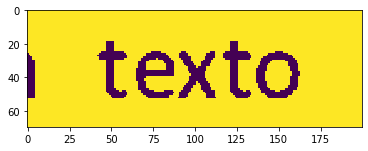

In [251]:
ims(imagenes_finales[5])

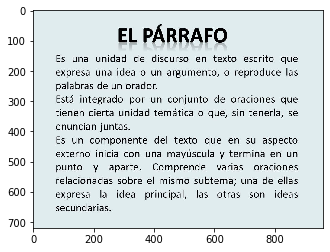

In [262]:
ims(orig)

In [162]:
def get_orden(lista_cord):
    total_centro = []
    definicion={}
    count = 0
    #Creando los puntos centrales.
    lista_cord.tolist()
    
    for i in lista_cord:
        count += 1
        centro=[]
        A = int((i[0] + i[2])/2)
        centro.append(A)
        B = int((i[1] + i[3])/2)
        centro.append(B)
        centro.append(count)
        total_centro.append(centro)
       
    #Sacando los rangos. 
    total_rangos_y=[]
    for i in lista_cord:
        rango=[]
        A = abs(int((i[1] - i[3])/2))
    for c in total_centro:
        rangos_y = []
        B_1 = c[1] + A
        rangos_y.append(B_1)
        B_2 = c[1] - A
        rangos_y.append(B_2)
        rangos_y.append(c[0])
        rangos_y.append(c[2])
        total_rangos_y.append(rangos_y)
    
    
    #Creando los grupos de los rangos
    rangos_ordenados= sorted(total_rangos_y)
    gas = []
    for r_y in range(len(rangos_ordenados)):
        que_rango=[]
        que_rango.append(rangos_ordenados[r_y])
        for r_y2 in range(len(rangos_ordenados)):
            if rangos_ordenados[r_y][0] <= rangos_ordenados[r_y2][0]*1.1 and rangos_ordenados[r_y][1] >= rangos_ordenados[r_y2][1]*0.9:
                que_rango.append(r_y2)
        gas.append(que_rango)
        
    #Si solo con rangos no funciona.
    #for grupos in range(len(gas)):
        #for n_grupos in range(len(gas)):
            #if gas[grupos][2] == gas[n_grupos][2] and gas[grupos][2] == gas[n_grupos][2]:
                #print('Tikit')
                
    #Ordenando primero por la x y luego por la y, ya tenemos el orden correcto.
    from operator import itemgetter
    import operator 
    #gas = sorted(gas, key=operator.itemgetter(1, 2))
    gas.sort(key=lambda x: x[0][2])
    gas.sort(key=lambda x: x[1]) 

    
    #Crear una lista con las posiciones que deberian ser
    orden_final=[]
    cuenta = 0
    for orden in gas:
        l_cuenta=[]
        cuenta += 1
        l_cuenta.append(cuenta)
        l_cuenta.append(orden[0][3])
        orden_final.append(l_cuenta)
    
    #Meter toda la info en un dicc
    for num in range(len(total_centro)):
        definicion[num]='Centros:',total_centro[num],'Rangos y:', gas[num], 'Orden:',orden_final[num]
        orden_final[num]=orden_final[num]
    
    #Añadir a cada source su posicion concreta
    lista_cord_copy = lista_cord.tolist()
 
    for i in range(1,len(lista_cord)+1):
        for j in orden_final:          
                if i == j[1]:
                    lista_cord_copy[i-1].append(j[0])
                    #lista_cord_copy[3] = j[0]
                    pass
    
    
    #ordenando por posicion.
    lista_cord_copy.sort(key=lambda x: x[4])
    
    for i in range(len(lista_cord_copy)):
          lista_cord_copy[i].pop(4)
    
    
    lista_cord_copy = abs(np.array(lista_cord_copy))
    return lista_cord_copy


In [61]:
image = cv2.imread("imagenes/ping2.jpeg")

(alt, anc) = image.shape[:2]

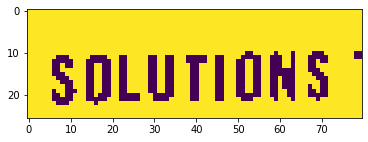

In [133]:
ims(imagenes_finales[3])

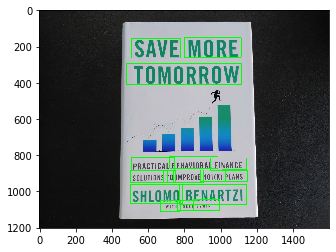

In [129]:
ims(orig)

In [10]:
#Adaptacion entre el tamaño de la imagen, el size que se pasa, el valor para resicear y el porcentaje de pading.

#Si la imagen es mas pequeña el size tiene que ser mas pequeño y el resice mas grande, y el pading mas grande.

In [35]:
#idiomas = [afr (Afrikaans), amh (Amharic), ara (Arabic), asm (Assamese), aze (Azerbaijani), aze_cyrl (Azerbaijani - Cyrilic), bel (Belarusian), ben (Bengali), bod (Tibetan), bos (Bosnian), bre (Breton), bul (Bulgarian), cat (Catalan; Valencian), ceb (Cebuano), ces (Czech), chi_sim (Chinese simplified), chi_tra (Chinese traditional), chr (Cherokee), cym (Welsh), dan (Danish), deu (German), dzo (Dzongkha), ell (Greek, Modern, 1453-), eng (English), enm (English, Middle, 1100-1500), epo (Esperanto), equ (Math / equation detection module), est (Estonian), eus (Basque), fas (Persian), fin (Finnish), fra (French), frk (Frankish), frm (French, Middle, ca.1400-1600), gle (Irish), glg (Galician), grc (Greek, Ancient, to 1453), guj (Gujarati), hat (Haitian; Haitian Creole), heb (Hebrew), hin (Hindi), hrv (Croatian), hun (Hungarian), iku (Inuktitut), ind (Indonesian), isl (Icelandic), ita (Italian), ita_old (Italian - Old), jav (Javanese), jpn (Japanese), kan (Kannada), kat (Georgian), kat_old (Georgian - Old), kaz (Kazakh), khm (Central Khmer), kir (Kirghiz; Kyrgyz), kmr (Kurdish Kurmanji), kor (Korean), kor_vert (Korean vertical), kur (Kurdish), lao (Lao), lat (Latin), lav (Latvian), lit (Lithuanian), ltz (Luxembourgish), mal (Malayalam), mar (Marathi), mkd (Macedonian), mlt (Maltese), mon (Mongolian), mri (Maori), msa (Malay), mya (Burmese), nep (Nepali), nld (Dutch; Flemish), nor (Norwegian), oci (Occitan post 1500), ori (Oriya), osd (Orientation and script detection module), pan (Panjabi; Punjabi), pol (Polish), por (Portuguese), pus (Pushto; Pashto), que (Quechua), ron (Romanian; Moldavian; Moldovan), rus (Russian), san (Sanskrit), sin (Sinhala; Sinhalese), slk (Slovak), slv (Slovenian), snd (Sindhi), spa (Spanish; Castilian), spa_old (Spanish; Castilian - Old), sqi (Albanian), srp (Serbian), srp_latn (Serbian - Latin), sun (Sundanese), swa (Swahili), swe (Swedish), syr (Syriac), tam (Tamil), tat (Tatar), tel (Telugu), tgk (Tajik), tgl (Tagalog), tha (Thai), tir (Tigrinya), ton (Tonga), tur (Turkish), uig (Uighur; Uyghur), ukr (Ukrainian), urd (Urdu), uzb (Uzbek), uzb_cyrl (Uzbek - Cyrilic), vie (Vietnamese), yid (Yiddish), yor (Yoruba)]

In [57]:
frase = image_to_text("imagenes/ping.jpeg",20)

[INFO] loading EAST text detector...
[INFO] text detection took 0.245145 seconds
La mesa de ping pong solo podra usarse durante al horario de comida Comprendide entre las 13:00 las 15:00 IRON 


In [25]:
#orig, imagenes_finales, palabras_text, frase = image_to_text("imagenes/ping.jpeg",20)

In [26]:
ims(orig)

NameError: name 'orig' is not defined

In [150]:
#Libreria leer foto, pruebas.
#imagen = cv2.imread("tesseract-python/piz1.jpeg")
#ocrtext1 = get_text.ocr(imagen)
frase

'Pieces détachées et SA Spare parts and aftersales service /'

In [55]:
from googletrans import Translator

In [56]:
import googletrans

In [66]:
#translator = Translator()
#translated = translator.translate('안녕하세요')

In [83]:
def traduce():              
    traductor=Translator()
    traduccion=traductor.translate(frase)
    print(traduccion)
    return traduccion.text

In [86]:
gas = traduce()

Translated(src=es, dest=en, text=Ping pong table can only be used during business hours Understood food between 13:00 15:00 Ne IP yey, pronunciation=Ping pong table can only be used during business hours Understood food between 13:00 15:00 Ne IP yey, extra_data="{'translat...")


In [80]:
gas

'Hello good Morning'

In [21]:
#from translate import translator
#translator('en', 'zh-TW', 'Hello World!')


In [15]:
import concurrent.futures
import goslate


In [31]:
executor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
gs = goslate.Goslate(executor=executor)
traduccion = gs.translate("palabras", "en")

In [32]:
traduccion

'words'

In [60]:
#executor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
#gs = goslate.Goslate(executor=executor)
#gs.translate("hola mundo", "en")

In [33]:
def traducir_palabra(palabra, leng):
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    gs = goslate.Goslate(executor=executor)
    traduccion = gs.translate(palabra, leng)
    return traduccion

In [39]:
traduccion = traducir_palabra("hola mundo", "en")

HTTPError: HTTP Error 429: Too Many Requests

In [35]:
traduccion

'Hello World'

In [37]:
#Idiomas para traducir.
{u'gu': u'Gujarati', u'zh-TW': u'Chinese (Traditional)', u'ga': u'Irish', u'gl': u'Galician', u'la': u'Latin', u'lo': u'Lao', u'tr': u'Turkish', u'lv': u'Latvian', u'lt': u'Lithuanian', u'th': u'Thai', u'tg': u'Tajik', u'te': u'Telugu', u'ta': u'Tamil', u'yi': u'Yiddish', u'ceb': u'Cebuano', u'yo': u'Yoruba', u'de': u'German', u'da': u'Danish', u'el': u'Greek', u'eo': u'Esperanto', u'en': u'English', u'zh': u'Chinese', u'eu': u'Basque', u'et': u'Estonian', u'es': u'Spanish', u'ru': u'Russian', u'zh-CN': u'Chinese (Simplified)', u'ro': u'Romanian', u'be': u'Belarusian', u'bg': u'Bulgarian', u'ms': u'Malay', u'bn': u'Bengali', u'jw': u'Javanese', u'bs': u'Bosnian', u'ja': u'Japanese', u'ca': u'Catalan', u'cy': u'Welsh', u'cs': u'Czech', u'pt': u'Portuguese', u'tl': u'Filipino', u'pa': u'Punjabi', u'vi': u'Vietnamese', u'pl': u'Polish', u'hy': u'Armenian', u'hr': u'Croatian', u'ht': u'Haitian Creole', u'hu': u'Hungarian', u'hmn': u'Hmong', u'hi': u'Hindi', u'ha': u'Hausa', u'mg': u'Malagasy', u'uz': u'Uzbek', u'ml': u'Malayalam', u'mn': u'Mongolian', u'mi': u'Maori', u'mk': u'Macedonian', u'ur': u'Urdu', u'mt': u'Maltese', u'uk': u'Ukrainian', u'mr': u'Marathi', u'my': u'Myanmar (Burmese)', u'af': u'Afrikaans', u'sw': u'Swahili', u'is': u'Icelandic', u'it': u'Italian', u'iw': u'Hebrew', u'kn': u'Kannada', u'ar': u'Arabic', u'km': u'Khmer', u'zu': u'Zulu', u'az': u'Azerbaijani', u'id': u'Indonesian', u'ig': u'Igbo', u'nl': u'Dutch', u'no': u'Norwegian', u'ne': u'Nepali', u'ny': u'Chichewa', u'fr': u'French', u'fa': u'Persian', u'fi': u'Finnish', u'ka': u'Georgian', u'kk': u'Kazakh', u'sr': u'Serbian', u'sq': u'Albanian', u'ko': u'Korean', u'sv': u'Swedish', u'su': u'Sundanese', u'st': u'Sesotho', u'sk': u'Slovak', u'si': u'Sinhala', u'so': u'Somali', u'sl': u'Slovenian'}

{'gu': 'Gujarati',
 'zh-TW': 'Chinese (Traditional)',
 'ga': 'Irish',
 'gl': 'Galician',
 'la': 'Latin',
 'lo': 'Lao',
 'tr': 'Turkish',
 'lv': 'Latvian',
 'lt': 'Lithuanian',
 'th': 'Thai',
 'tg': 'Tajik',
 'te': 'Telugu',
 'ta': 'Tamil',
 'yi': 'Yiddish',
 'ceb': 'Cebuano',
 'yo': 'Yoruba',
 'de': 'German',
 'da': 'Danish',
 'el': 'Greek',
 'eo': 'Esperanto',
 'en': 'English',
 'zh': 'Chinese',
 'eu': 'Basque',
 'et': 'Estonian',
 'es': 'Spanish',
 'ru': 'Russian',
 'zh-CN': 'Chinese (Simplified)',
 'ro': 'Romanian',
 'be': 'Belarusian',
 'bg': 'Bulgarian',
 'ms': 'Malay',
 'bn': 'Bengali',
 'jw': 'Javanese',
 'bs': 'Bosnian',
 'ja': 'Japanese',
 'ca': 'Catalan',
 'cy': 'Welsh',
 'cs': 'Czech',
 'pt': 'Portuguese',
 'tl': 'Filipino',
 'pa': 'Punjabi',
 'vi': 'Vietnamese',
 'pl': 'Polish',
 'hy': 'Armenian',
 'hr': 'Croatian',
 'ht': 'Haitian Creole',
 'hu': 'Hungarian',
 'hmn': 'Hmong',
 'hi': 'Hindi',
 'ha': 'Hausa',
 'mg': 'Malagasy',
 'uz': 'Uzbek',
 'ml': 'Malayalam',
 'mn': 'Mon

In [145]:
#import goslate
#gs = goslate.Goslate()
#print(gs.translate('hello world', 'es'))

In [19]:
def unificar_texto(palabras_text):
    palabra_unida = ' '.join(palabras_text)
    print(palabra_unida)
    return palabra_unida

In [51]:
frase = unificar_texto(palabras_text)

L2 mesa de ping pong solo podra usarse durante el horario de comida Comprendido entre las 13:00 las 15:00 IRON! =ria'@


In [10]:
from gtts import gTTS  
import os 
from pydub import AudioSegment
from pydub.playback import play
  

def get_audio(palabra_unida):
    mytext = palabra_unida
    myobj = gTTS(mytext, lang='es-us')    
    myobj.save("welcome.mp3")
    song = AudioSegment.from_mp3("welcome.mp3")
    play(song)


In [20]:
get_audio(frase)

NameError: name 'frase' is not defined

In [140]:

##Porque no funciona si lo paso al visual

def get_orden(lista_cord):
    total_centro = []
    definicion={}
    count = 0
    #Creando los puntos centrales.
    lista_cord.tolist()
    
    for i in lista_cord:
        count += 1
        centro=[]
        A = int((i[0] + i[2])/2)
        centro.append(A)
        B = int((i[1] + i[3])/2)
        centro.append(B)
        centro.append(count)
        total_centro.append(centro)
       
    #Sacando los rangos. 
    total_rangos_y=[]
    for i in lista_cord:
        rango=[]
        A = abs(int((i[1] - i[3])/2))
    for c in total_centro:
        rangos_y = []
        B_1 = c[1] + A
        rangos_y.append(B_1)
        B_2 = c[1] - A
        rangos_y.append(B_2)
        rangos_y.append(c[0])
        rangos_y.append(c[2])
        total_rangos_y.append(rangos_y)
    
    
    #Creando los grupos de los rangos
    rangos_ordenados= sorted(total_rangos_y)
    gas = []
    for r_y in range(len(rangos_ordenados)):
        que_rango=[]
        que_rango.append(rangos_ordenados[r_y])
        for r_y2 in range(len(rangos_ordenados)):
            if rangos_ordenados[r_y][0]*1.5 <= rangos_ordenados[r_y2][0]*1.5 and rangos_ordenados[r_y][1]*0.5 >= rangos_ordenados[r_y2][1]*0.5:
                que_rango.append(r_y2)
        gas.append(que_rango)
        
    #Si solo con rangos no funciona.
    #for grupos in range(len(gas)):
        #for n_grupos in range(len(gas)):
            #if gas[grupos][2] == gas[n_grupos][2] and gas[grupos][2] == gas[n_grupos][2]:
                #print('Tikit')
                
    #Ordenando primero por la x y luego por la y, ya tenemos el orden correcto.
    from operator import itemgetter
    import operator 
    #gas = sorted(gas, key=operator.itemgetter(1, 2))
    gas.sort(key=lambda x: x[0][2])
    gas.sort(key=lambda x: x[1]) 

    
    #Crear una lista con las posiciones que deberian ser
    orden_final=[]
    cuenta = 0
    for orden in gas:
        l_cuenta=[]
        cuenta += 1
        l_cuenta.append(cuenta)
        l_cuenta.append(orden[0][3])
        orden_final.append(l_cuenta)
    
    #Meter toda la info en un dicc
    for num in range(len(total_centro)):
        definicion[num]='Centros:',total_centro[num],'Rangos y:', gas[num], 'Orden:',orden_final[num]
        orden_final[num]=orden_final[num]
    
    #Añadir a cada source su posicion concreta
    lista_cord_copy = lista_cord.tolist()
 
    for i in range(1,len(lista_cord)+1):
        for j in orden_final:          
                if i == j[1]:
                    lista_cord_copy[i-1].append(j[0])
                    #lista_cord_copy[3] = j[0]
                    pass
    
    
    #ordenando por posicion.
    lista_cord_copy.sort(key=lambda x: x[4])
    
    for i in range(len(lista_cord_copy)):
          lista_cord_copy[i].pop(4)
    
    
    lista_cord_copy = abs(np.array(lista_cord_copy))
    return lista_cord_copy


In [27]:
#Cemtro +- altura/2 = rango
Orde

NameError: name 'Orde' is not defined

In [19]:
cv2.imshow("gas",partes_imagen[5])
cv2.waitKey(0)

NameError: name 'partes_imagen' is not defined

In [188]:
#gray = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

In [18]:
#gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)


In [200]:
#Para pasar a blanco y negro
#(thresh, blackAndWhiteImage) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

In [202]:
#tratado2 = cv2.medianBlur(blackAndWhiteImage, 3)

In [158]:
#Conclusiones a tener en cuenta

# - Cuanto mas se afina el resize mejor funciona al reconocedor de texto.